## Import library

In [30]:
import joblib
import re
!pip install sklearn
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import scipy.sparse

import bs4 as bs  
import re  
from sklearn.metrics import classification_report, make_scorer

from sklearn.metrics import f1_score,balanced_accuracy_score,accuracy_score

import warnings
warnings.filterwarnings("ignore")

import itertools
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()
from sklearn.base import clone
import time

In [ ]:
import pandas as pd
import numpy as np  
import random  
import string
import unicodedata
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,LSTM, Activation,Bidirectional, GlobalMaxPool1D
from keras.layers.core import Reshape, Flatten
from keras.models import Model

# Sentiment

## Cleaning

In [15]:
data = pd.read_excel('../Data/data_baru.xlsx')
stop_words = open("../Data/stopword.txt", "r").read().split()
dic = pd.read_csv('../Data/normalize_word.csv')

In [16]:
def normalize(text):
    text = text.split()
    for val in dic.itertuples(index=False):
        text = [w.replace(val.slang, val.formal) if w == val.slang else w for w in text]
    return " ".join(text)

In [17]:
# bersihkan teks
def clean_text(text,stopwords):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stopwords])
    return text
data['content'] = data['content'].apply(clean_text,stopwords=stop_words)

In [18]:
%%time
# df.apply(some_func, var1='DOG', axis=1)
data['content'] = data['content'].apply(clean_text,stopwords=stop_words)
# data['content'] = data['content'].apply(normalize)

CPU times: user 1.76 s, sys: 5 ms, total: 1.77 s
Wall time: 1.77 s


In [19]:
def checkLen(data):
  return len(data.split())
data['Len'] = data['content'].apply(checkLen)

In [20]:
len(data)

625

In [21]:
data = data[data['Len'] > 10].reset_index(drop=True)

In [22]:
len(data)

619

In [23]:
data = data[data['Label Sentimen Analysis'].isin([1.0,-1.0])]

In [24]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.8

df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 352
TEST size: 89


## Feature Extraction

In [27]:
# data = dataCheck.copy()
# # Ubah fitur menjadi bentuk TFIDF dengan jumlah kata 150
mx_feat = 1000
vectorizer = CountVectorizer(max_features=mx_feat)
bow_data_train = vectorizer.fit_transform(df_train['content'])
bow_data_train = pd.DataFrame.sparse.from_spmatrix(bow_data_train,columns=vectorizer.get_feature_names())

bow_data_test = vectorizer.transform(df_test['content'])
bow_data_test = pd.DataFrame.sparse.from_spmatrix(bow_data_test,columns=vectorizer.get_feature_names())
# data = data.join(bow_data)

In [ ]:
joblib.dump(vectorizer, 'CountVectorizerSentimen.pkl')

['CountVectorizerSentimen.pkl']

## Modeling

In [ ]:
# Metrics
from sklearn.metrics import accuracy_score

In [ ]:
x_train = bow_data_train.values
x_test = bow_data_test.values

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_train['Label Sentimen Analysis'].tolist())

y_train = encoder.transform(df_train['Label Sentimen Analysis'].tolist())
y_test = encoder.transform(df_test['Label Sentimen Analysis'].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (352, 1)
y_test (89, 1)


In [ ]:
dropout = 0.1
def make_nn(dropout):
  inputs = Input(shape=(mx_feat,))
  layer = Dropout(dropout)(inputs)
  layer = Dense(16, activation="relu")(layer)
  layer = Dense(16, activation="relu")(layer)
  layer = Dense(1, activation="sigmoid")(layer)
  model = Model(inputs, layer)
  return model
model = make_nn(dropout)

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 10))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=70, callbacks=[lr_schedule],verbose=1)

Epoch 1/70
44/44 [==============================] - 1s 9ms/step - loss: 0.7585 - accuracy: 0.4315 - val_loss: 0.7637 - val_accuracy: 0.3820
Epoch 2/70
44/44 [==============================] - 0s 2ms/step - loss: 0.7498 - accuracy: 0.4541 - val_loss: 0.7634 - val_accuracy: 0.3820
Epoch 3/70
44/44 [==============================] - 0s 3ms/step - loss: 0.7578 - accuracy: 0.4514 - val_loss: 0.7630 - val_accuracy: 0.3820
Epoch 4/70
44/44 [==============================] - 0s 3ms/step - loss: 0.7739 - accuracy: 0.4002 - val_loss: 0.7626 - val_accuracy: 0.3820
Epoch 5/70
44/44 [==============================] - 0s 2ms/step - loss: 0.7612 - accuracy: 0.4093 - val_loss: 0.7620 - val_accuracy: 0.3820
Epoch 6/70
44/44 [==============================] - 0s 3ms/step - loss: 0.7743 - accuracy: 0.3972 - val_loss: 0.7613 - val_accuracy: 0.3820
Epoch 7/70
44/44 [==============================] - 0s 2ms/step - loss: 0.7741 - accuracy: 0.4214 - val_loss: 0.7604 - val_accuracy: 0.3820
Epoch 8/70
44/44 [==

(1e-06, 1.0, 0.0, 2.0)

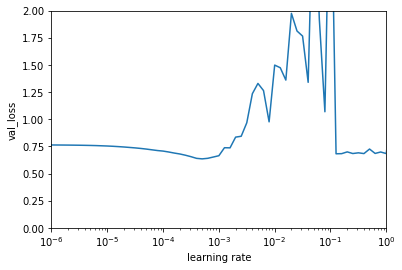

In [ ]:
plt.xlabel('learning rate')
plt.ylabel('val_loss')
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e0, 0, 2])

In [ ]:
model = make_nn(dropout)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=2*1e-4), metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=20,verbose=1)

Epoch 1/20
44/44 [==============================] - 1s 9ms/step - loss: 0.6559 - accuracy: 0.6216 - val_loss: 0.6794 - val_accuracy: 0.5506
Epoch 2/20
44/44 [==============================] - 0s 2ms/step - loss: 0.6602 - accuracy: 0.5929 - val_loss: 0.6718 - val_accuracy: 0.5618
Epoch 3/20
44/44 [==============================] - 0s 3ms/step - loss: 0.5929 - accuracy: 0.6570 - val_loss: 0.6646 - val_accuracy: 0.5843
Epoch 4/20
44/44 [==============================] - 0s 3ms/step - loss: 0.5575 - accuracy: 0.6925 - val_loss: 0.6568 - val_accuracy: 0.5955
Epoch 5/20
44/44 [==============================] - 0s 3ms/step - loss: 0.5342 - accuracy: 0.7049 - val_loss: 0.6504 - val_accuracy: 0.6292
Epoch 6/20
44/44 [==============================] - 0s 3ms/step - loss: 0.5035 - accuracy: 0.7016 - val_loss: 0.6452 - val_accuracy: 0.6180
Epoch 7/20
44/44 [==============================] - 0s 3ms/step - loss: 0.5074 - accuracy: 0.6974 - val_loss: 0.6396 - val_accuracy: 0.6517
Epoch 8/20
44/44 [==

In [ ]:
X_pred = model.predict(x_test).round()

In [ ]:
accuracy_score(X_pred,y_test)

0.8089887640449438

In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


## Pipeline

In [29]:
CountVectorizer = joblib.load('/content/CountVectorizerSentimen.pkl')  
stop_words = open("/content/stopword.txt", "r").read().split()
model = tf.keras.models.load_model('model')

In [ ]:
data = pd.read_excel('/content/data_baru.xlsx')

In [ ]:
# bersihkan teks
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

In [ ]:
def normalize(text):
    text = text.split()
    for val in dic.itertuples(index=False):
        text = [w.replace(val.slang, val.formal) if w == val.slang else w for w in text]
    return " ".join(text)

In [ ]:
def vectorize_verif(data):
  bow_data = CountVectorizer.transform(data['content'])
  bow_data = pd.DataFrame.sparse.from_spmatrix(bow_data,columns=CountVectorizer.get_feature_names())
  return bow_data

In [ ]:
def predict_data(data):
  data['content'] = data['content'].apply(clean_text)
  data['content'] = data['content'].apply(clean_text)
  bow_data = vectorize_verif(data)
  return model.predict(bow_data)

In [ ]:
# res = encoder.transform(data['Label Sentimen Analysis'])
pred = predict_data(data)

In [ ]:
def changeLabel(value):
  if value > 0.6:
    return 1
  elif value < 0.4:
    return -1
  else:
    return 0
vchangeLabel = np.vectorize(changeLabel)
data['Label Sentimen Analysis'] = vchangeLabel(pred)

# ML 2

## Cleaning

In [31]:
import pandas as pd


data = pd.read_excel('../Data/data_baru.xlsx')
stop_words = open("../Data/stopword.txt", "r").read().split()
dic = pd.read_csv('../Data/normalize_word.csv')

In [32]:
def normalize(text):
    text = text.split()
    for val in dic.itertuples(index=False):
        text = [w.replace(val.slang, val.formal) if w == val.slang else w for w in text]
    return " ".join(text)

In [33]:
import re
import string

# bersihkan teks
def clean_text(text,stopwords):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stopwords])
    return text
data['content'] = data['content'].apply(clean_text,stopwords=stop_words)

In [34]:
%%time
data['content'] = data['content'].apply(clean_text, stopwords=stop_words)
data['content'] = data['content'].apply(normalize)

CPU times: user 1min 8s, sys: 109 ms, total: 1min 8s
Wall time: 1min 8s


In [35]:
def checkLen(data):
  return len(data.split())
data['Len'] = data['content'].apply(checkLen)

In [36]:
len(data)

625

In [37]:
data = data[data['Len'] > 10].reset_index(drop=True)

In [38]:
len(data)

619

In [39]:
data = data[data['sentiment'].isin([1.0,-1.0])]

In [40]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.8

df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 352
TEST size: 89


## Word2vec

In [41]:
%%time
documents = [_content.split() for _content in df_train.content] 

CPU times: user 11.9 ms, sys: 2 ms, total: 13.9 ms
Wall time: 17.1 ms


In [42]:
import gensim

# WORD2VEC 
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [43]:
w2v_model.build_vocab(documents)


In [44]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1705


In [45]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 5.73 s, sys: 90.7 ms, total: 5.82 s
Wall time: 3.25 s


(1675646, 2550496)

In [46]:
w2v_model.most_similar("jakarta")


[('medan', 0.6947625279426575),
 ('merdeka', 0.625023365020752),
 ('kompascom', 0.6201826930046082),
 ('pemprov', 0.6006861925125122),
 ('timur', 0.5864685773849487),
 ('gubernur', 0.5797368288040161),
 ('banten', 0.5688251256942749),
 ('balai', 0.5651791095733643),
 ('pulau', 0.5613480806350708),
 ('baswedan', 0.5608643889427185)]

In [47]:
%%time

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.content)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 11862
CPU times: user 1.64 s, sys: 262 ms, total: 1.91 s
Wall time: 1.92 s


In [48]:
%%time

from keras.preprocessing.sequence import pad_sequences

# KERAS
SEQUENCE_LENGTH = 200

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.content), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.content), maxlen=SEQUENCE_LENGTH)

CPU times: user 62.9 ms, sys: 3.93 ms, total: 66.9 ms
Wall time: 64.7 ms


In [49]:
labels = []
labels = df_train.sentiment.unique().tolist()
labels

[-1, 1]

In [50]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_train.sentiment.tolist())

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (352, 1)
y_test (89, 1)


In [51]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (352, 200)
y_train (352, 1)

x_test (89, 200)
y_test (89, 1)


In [52]:
import numpy as np

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(11862, 200)


## LSTM

In [59]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

model = Sequential()
model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          2372400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,492,901
Trainable params: 120,501
Non-trainable params: 2,372,400
_________________________________________________________________


In [54]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [55]:
%%time
import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 8

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 10), verbose=1)

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=[lr_schedule],
                    verbose=1)

Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
40/40 [==============================] - 37s 331ms/step - loss: 0.6858 - acc: 0.5447 - val_loss: 0.6534 - val_acc: 0.5833
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2589254117941672e-06.
40/40 [==============================] - 12s 302ms/step - loss: 0.6724 - acc: 0.5681 - val_loss: 0.6531 - val_acc: 0.5833
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5848931924611134e-06.
40/40 [==============================] - 12s 303ms/step - loss: 0.6562 - acc: 0.5884 - val_loss: 0.6525 - val_acc: 0.5833
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate to 1.9952623149688796e-06.
40/40 [==============================] - 12s 305ms/step - loss: 0.6747 - acc: 0.5305 - val_loss: 0.6520 - val_acc: 0.5833
Epoch 5/60

Epoch 00005: LearningRateScheduler reducing learning rate to 2.51188643150958e-06.
40/40 [==============================] - 12s 3

(1e-06, 1.0, 0.0, 2.0)

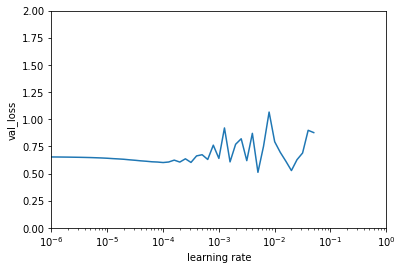

In [56]:
import matplotlib.pyplot as plt

plt.xlabel('learning rate')
plt.ylabel('val_loss')
plt.semilogx(history.history["lr"], history.history["val_loss"])
plt.axis([1e-6, 1e0, 0, 2])

In [60]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.00025118864315095795), metrics=['accuracy'])

history = model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=10,verbose=1)

Epoch 1/10
44/44 [==============================] - 16s 297ms/step - loss: 0.6854 - accuracy: 0.5230 - val_loss: 0.6535 - val_accuracy: 0.5843
Epoch 2/10
44/44 [==============================] - 12s 274ms/step - loss: 0.6191 - accuracy: 0.6715 - val_loss: 0.6565 - val_accuracy: 0.6292
Epoch 3/10
44/44 [==============================] - 12s 274ms/step - loss: 0.5877 - accuracy: 0.6763 - val_loss: 0.6484 - val_accuracy: 0.6742
Epoch 4/10
44/44 [==============================] - 12s 276ms/step - loss: 0.5726 - accuracy: 0.7228 - val_loss: 0.6381 - val_accuracy: 0.6966
Epoch 5/10
44/44 [==============================] - 12s 273ms/step - loss: 0.5329 - accuracy: 0.7468 - val_loss: 0.6629 - val_accuracy: 0.7079
Epoch 6/10
44/44 [==============================] - 12s 273ms/step - loss: 0.5569 - accuracy: 0.7051 - val_loss: 0.6109 - val_accuracy: 0.7191
Epoch 7/10
44/44 [==============================] - 12s 273ms/step - loss: 0.4792 - accuracy: 0.7705 - val_loss: 0.6159 - val_accuracy: 0.7079

In [61]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

12/12 [==============================] - 0s 38ms/step - loss: 0.6311 - accuracy: 0.7191

ACCURACY: 0.7191011309623718
LOSS: 0.6310719847679138
CPU times: user 844 ms, sys: 13.5 ms, total: 857 ms
Wall time: 510 ms
